[![Open in
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slitvinov/odil-examples/blob/main/iterations.ipynb)

# Explanation of the Wave Equation Solver

This notebook cell implements a **least-squares solution** of the **1D wave equation** on a space–time grid.

---

## 1. The PDE

We want to solve the **1D wave equation**:

$$
u_{tt} - u_{xx} = 0, \quad (t,x) \in [0,T]\times[-L,L]
$$

with conditions:

- **Initial condition (at \(t=0\)):**
$$
u(0,x) = \exp\!\Big(-\frac{x^2}{\sigma^2}\Big)
$$

- **Boundary conditions (at \(x=-L,\,x=L\)):**
$$
u(t, -L) = u(t, L) = 0
$$

- **Terminal condition (at \(t=T\)):**
$$
u(T, x) = 0
$$

---

## 2. Discretization

We discretize the domain with:
- \(nx\) spatial points, spacing
$$
dx = \frac{2L}{nx-1}
$$
- \(nt\) time points, spacing
$$
dt = \frac{T}{nt}
$$

The centered finite-difference approximation of the wave operator is:

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{dt^2}
-
\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{dx^2} = 0
$$

which, after rearrangement, gives coefficients:

$$
c_1 = \frac{1}{2 dt^2}, \quad
c_0 = -\frac{1}{2 dx^2}, \quad
c_2 = -\frac{dx^2 - dt^2}{dt^2 dx^2}.
$$

Thus, each interior equation couples five unknowns:

$$
c_1 u_{i-1,j} + c_0 u_{i,j-1} + c_2 u_{i,j} + c_0 u_{i,j+1} + c_1 u_{i+1,j} = 0
$$

---

## 3. Sparse matrix construction

The code builds two sparse matrices:

- **`dF` (PDE + boundary + terminal constraints):**  
  - For interior nodes, encodes the wave stencil above.  
  - For boundary/terminal nodes, enforces $$u=0$$ by inserting identity rows.

- **`dG` (initial condition at \(t=0\)):**  
  - At $$t=0$$, enforces
    $$
    u(0,x_j) = \exp\!\Big(-\frac{x_j^2}{\sigma^2}\Big)
    $$
    via identity rows.  
  - Elsewhere, adds no extra constraint.

Both are stored in **CSR sparse format**.

---

## 4. Least-squares formulation

We want to minimize:

$$
\min_u \; \|dF u + f\|_2^2 + \|dG u + g\|_2^2
$$

where $$u$$ is the vector of all unknowns $$u_{i,j}$$ flattened into size $$nt \times nx$$.

This is solved using the **normal equations**:

$$
M u = dF^T f + dG^T g - M u_{\text{old}}
$$

with

$$
M = dF^T dF + dG^T dG
$$

The code iterates a few times, but since the system is linear, **one solve is enough**.


diff: 6.1039e-02
diff: 8.2190e-15
diff: 4.0774e-14
diff: 1.1084e-14
diff: 3.3388e-13


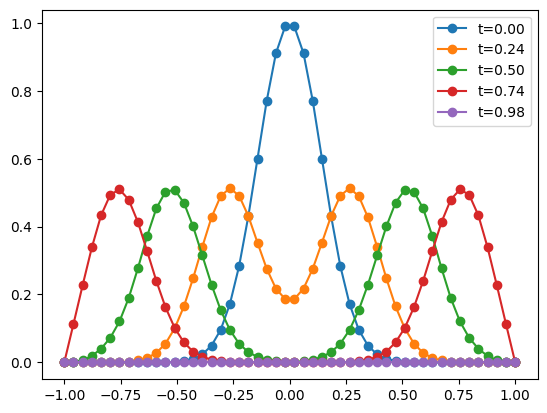

In [1]:
import scipy
import matplotlib.pyplot as plt
import math
import numpy as np


def cappend(i, j, d):
    row.append(len(rhs))
    col.append(i * nx + j)
    data.append(d)


nx = 50
nt = 50
L = 1.0
T = 1.0
sigma = 0.2
dx = 2 * L / (nx - 1)
dt = T / nt
c0 = -1 / (2 * dx**2)
c1 = 1 / (2 * dt**2)
c2 = -((dx**2 - dt**2) / (dt**2 * dx**2))
x = np.linspace(-L, L, nx)

row = []
col = []
rhs = []
data = []
for i in range(nt):
    for j in range(nx):
        if i == 0:
            cappend(0, j, 0)
            rhs.append(0)
        elif i == nt - 1:
            cappend(nt - 1, j, 0)
            rhs.append(0)
        elif j == 0 or j == nx - 1:
            cappend(i, j, 0)
            rhs.append(0)
        else:
            cappend(i - 1, j, c1)
            cappend(i, j - 1, c0)
            cappend(i, j, c2)
            cappend(i, j + 1, c0)
            cappend(i + 1, j, c1)
            rhs.append(0)
dF = scipy.sparse.csr_matrix((data, (row, col)), dtype=float)
f = np.copy(rhs)

row = []
col = []
rhs = []
data = []
for i in range(nt):
    for j in range(nx):
        if i == 0:
            cappend(0, j, 1)
            rhs.append(math.exp(-(x[j] / sigma)**2))
        elif i == nt - 1:
            cappend(nt - 1, j, 1)
            rhs.append(0)
        elif j == 0 or j == nx - 1:
            cappend(i, j, 1)
            rhs.append(0)
        else:
            cappend(i, j, 0)
            rhs.append(0)
dG = scipy.sparse.csr_matrix((data, (row, col)), dtype=float)
g = np.copy(rhs)

us = np.zeros(nt * nx)
for i in range(5):
    Fs = dF @ us + f
    Gs = dG @ us + g
    M = dF.T @ dF + dG.T @ dG
    rhs = -M @ us + dF.T @ Fs + dG.T @ Gs
    usp = scipy.sparse.linalg.spsolve(M, rhs)
    print(f"diff: {np.mean((usp - us)**2):8.4e}")
    us = usp
u = np.asarray(us).reshape(nt, nx)
for k in 0, nt // 4, nt // 2, 3 * nt // 4, nt - 1:
    plt.plot(x, u[k, :], 'o-', label=f"t={k*dt:.2f}")
plt.legend()